In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
from analysis import model_generated, selection, add_variables, final_selection, phsp_generator
from k3pi_utilities import helpers
from matplotlib.backends.backend_pdf import PdfPages
from analysis.mass_fitting import get_yields
from k3pi_config.modes import MODE, gcm
from k3pi_config import config
config.candidates_selection = True
config.optimised_selection = True
from analysis import efficiencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from k3pi_plotting import comparison
from k3pi_config.modes.D0ToKpipipi_RS import D0ToKpipipi_RS as mode_config
from k3pi_utilities import variables as vars
import root_pandas
from collections import defaultdict
import pprint
from scipy import stats, special
import uncertainties
from uncertainties.umath import sqrt, atan
from k3pi_plotting import utils as plot_utils

@np.vectorize
def compute_angular(x,y,xe=None,ye=None):
    if xe is None or ye is None:
        return np.sqrt(x**2+y**2), (np.arctan(y/x) + 2 * np.pi) % (2 * np.pi)
    ux = uncertainties.ufloat(x,xe)
    uy = uncertainties.ufloat(y,ye)
    ur = sqrt(ux**2+uy**2)
    up = atan(uy/ux)
    return ur.n, ur.s, (up.n + 2 * np.pi) % (2 * np.pi), up.s

@np.vectorize
def compute_rho(x, xe, y, ye):
    ux = uncertainties.ufloat(x,xe)
    uy = uncertainties.ufloat(y,ye)
    ur = sqrt(ux**2+uy**2)
    return ur.n, ur.s
    
true_values = {
    'NBkg': 105000,
    'NSig': 110000,
    'SqWStoRSrate': 1/np.sqrt(300),
    'xmixing': 0.0046,
    'ymixing': 0.0062,
}

pretty_names = {
    'NBkg': r'$N_{\mathrm{Bkg}}$',
    'NSig': r'$N_{\mathrm{Sig}}$',
    'SqWStoRSrate': r'$r$',
    'xmixing': r'$x^{\prime\prime\prime}$',
    'ymixing': r'$y^{\prime\prime\prime}$',
    'tau': r'$\tau$',
    'rho': r'$\rho$',

}

with open('./toy.cu') as f:
    lines = f.readlines()
    
cleaned = [l for l in lines if 'Variable(' in l]

def find_parens(s):
    toret = {}
    pstack = []

    for i, c in enumerate(s):
        if c == '(':
            pstack.append(i)
        elif c == ')':
            if len(pstack) == 0:
                raise IndexError("No matching closing parens at: " + str(i))
            toret[pstack.pop()] = i

    if len(pstack) > 0:
        raise IndexError("No matching opening parens at: " + str(pstack.pop()))

    return toret

def find_str(s, char, end=False):
    index = 0
    finds = []
    if char in s:
        c = char[0]
        for ch in s:
            if ch == c:
                if s[index:index+len(char)] == char:
                    finds += [index if end is False else index + len(char) - 1]

            index += 1

    return finds


true_values = {}
for line in cleaned:
    for start in find_str(line, 'Variable(', True):
        end = find_parens(line)[start]
        name, value, *_ = (line[start+1:end].split(','))

        try:
            true_values[name.replace('"','')] = float(value)
        except:
            pass
        

true_values.update({
    'NBkg': 87900,
    'NSig': 71170,
    'SqWStoRSrate': 1/np.sqrt(300),
    'xmixing': 0.0046,
    'ymixing': 0.0062,
})

tmp = {}
# Add magnitude and phase true vales
for var in true_values:
    if '_real' not in var:
        continue
    raw_var = var.replace('_real', '')
    tmp[raw_var + '_mag'], tmp[raw_var + '_arg'] = compute_angular(true_values[raw_var + '_real'], true_values[raw_var + '_imag'])
    
true_values.update(tmp)
true_values['rho'] = np.sqrt(true_values['xmixing']**2 + true_values['ymixing']**2)
    
raw_names = {
    'K892_rho770_S': r'\PKstar(892)^{0}[\PKp\Ppiminus]\rho(770)[\Ppiplus\Ppiminus]^\mathcal{S}',
    'K892_rho770_P': r'\PKstar(892)^{0}[\PKp\Ppiminus]\rho(770)[\Ppiplus\Ppiminus]^\mathcal{P}',
    'K892_rho770_D': r'\PKstar(892)^{0}[\PKp\Ppiminus]\rho(770)[\Ppiplus\Ppiminus]^\mathcal{D}',
    'rho1450_K0_1430': r'\rho(1450)[\Ppiplus\Ppiminus]K_0^*(1430)^*[\PKp\Ppiminus]',
    'K1_1270_K0_1430': r'\PK_1(1270)^{+}[\PKstar_0(1430)^{0}[\PKp\Ppiminus]\Ppiminus]\Ppiminus',
    'K1_1270_K892': r'\PK_1(1270)^{+}[\PKstar(892)^{0}[\PKp\Ppiminus]\Ppiplus]\Ppiminus',
    'K1_1270_rho770': r'\PK_1(1270)^{+}[\rho(770)[\Ppiplus\Ppiminus]\PKp]\Ppiminus',
    'K1_1400_K892': r'\PK_1(1400)^{+}[\PKstar(892)^{0}[\PKp\Ppiminus]\Ppiplus]',
    'nonRes': r'\text{(non-resonant)}'
}

from itertools import product
pretty_names.update({
    pref + val +'_imag' : r'$\Im\left({}\right)$'.format(raw_names[val]) for pref, val in product(['', 'WS_'], raw_names)
})
pretty_names.update({
    pref + val +'_mag' : r'$R\left({}\right)$'.format(raw_names[val]) for pref, val in product(['', 'WS_'], raw_names)
})
pretty_names.update({
    pref + val +'_real' : r'$\Re\left({}\right)$'.format(raw_names[val]) for pref, val in product(['', 'WS_'], raw_names)
})
pretty_names.update({
    pref + val +'_arg' : r'$\phi\left({}\right)$'.format(raw_names[val]) for pref, val in product(['', 'WS_'], raw_names)
})

/afs/cern.ch/user/d/dmuller/work/anaconda3/envs/k3pi_python3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/afs/cern.ch/user/d/dmuller/work/anaconda3/envs/k3pi_python3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
do_mag_arg = False
state = 'fixed'
outsuffix = f'ws_{state}_integration_rs'
outpath = 'fixed_signal'
if do_mag_arg:
    outsuffix += '_mag_arg'
toy = root_pandas.read_root(f'./toy_results/fixed_signal/{state}_ws_tau_fixed.root')

integration = root_pandas.read_root(f'./toy_results/fixed_signal/integration_ws_{state}_tau_fixed.root')
if 'SqWStoRSrate_v' in toy.columns:
    toy['SqWStoRSrate_v'] = toy['SqWStoRSrate_v']/toy['final_scale']
    toy['SqWStoRSrate_e'] = toy['SqWStoRSrate_e']/toy['final_scale']
if 'SqWStoRSrate_v' in integration.columns:
    integration['SqWStoRSrate_v'] = integration['SqWStoRSrate_v']/integration['final_scale']
    integration['SqWStoRSrate_e'] = integration['SqWStoRSrate_e']/integration['final_scale']
vars_in_sample = list([v for v in true_values if v+'_v' in toy.columns])

if do_mag_arg:
    mag_arg_vars = []
    for var in vars_in_sample:
        if '_real' in var:
            raw_var = var.replace('_real', '')
            toy[raw_var + '_mag_v'], toy[raw_var + '_mag_e'], toy[raw_var + '_arg_v'], toy[raw_var + '_arg_e'] = compute_angular(toy[raw_var + '_real_v'], toy[raw_var + '_imag_v'], toy[raw_var + '_real_e'], toy[raw_var + '_imag_e'])
            vars_in_sample += [raw_var + '_mag', raw_var + '_arg']
    vars_in_sample = [v for v in vars_in_sample if '_real' not in v and '_imag' not in v]

vars_in_sample += ['rho']
toy['rho_v'], toy['rho_e'] = compute_rho(toy['xmixing_v'], toy['xmixing_e'], toy['ymixing_v'], toy['ymixing_e'])
integration['rho_v'], integration['rho_e'] = compute_rho(integration['xmixing_v'], integration['xmixing_e'], integration['ymixing_v'], integration['ymixing_e'])


int_unc = defaultdict(lambda:0, {var: np.std((integration[var+'_v'] - true_values[var])/integration[var+'_e']) for var in list([v for v in true_values if v+'_v' in toy.columns and v+'_v' in integration.columns])})

In [12]:
systematics = {}
systematics['meson_radius'] = ('./toy_results/fixed_signal/floating_ws_tau_fixed_D0_radius_up.root', './toy_results/fixed_signal/floating_ws_tau_fixed_D0_radius_down.root')
systematics['res_radius'] = ('./toy_results/fixed_signal/floating_ws_tau_fixed_res_radius_up.root', './toy_results/fixed_signal/floating_ws_tau_fixed_res_radius_down.root')

In [14]:
systematics = {}
systematics['model'] = './toy_results/fixed_signal/floating_ws_tau_fixed_added_res.root'


In [15]:
for name, syst in systematics.items():
    if type(syst) == tuple:
        up = root_pandas.read_root(syst[0])
        up['rho_v'], up['rho_e'] = compute_rho(up['xmixing_v'], up['xmixing_e'], up['ymixing_v'], up['ymixing_e'])

        down = root_pandas.read_root(syst[1]) 
        down['rho_v'], down['rho_e'] = compute_rho(down['xmixing_v'], down['xmixing_e'], down['ymixing_v'], down['ymixing_e'])

        merged = toy.merge(up,  on='itoy', suffixes=('_ORG', '_UP'))
        A = np.mean((merged.rho_v_UP-merged.rho_v_ORG)/merged.rho_e_ORG)
        AA = np.mean((merged.rho_v_UP-merged.rho_v_ORG))

        merged = toy.merge(down,  on='itoy', suffixes=('_ORG', '_UP'))
        B = np.mean((merged.rho_v_UP-merged.rho_v_ORG)/merged.rho_e_ORG)
        BB = np.mean((merged.rho_v_UP-merged.rho_v_ORG))
        print(name, 0.5*np.abs(AA)+0.5*np.abs(BB))
        print(name, 0.5*np.abs(A)+0.5*np.abs(B), '%') 
    else:
        up = root_pandas.read_root(syst)
        up['rho_v'], up['rho_e'] = compute_rho(up['xmixing_v'], up['xmixing_e'], up['ymixing_v'], up['ymixing_e'])

        merged = toy.merge(up,  on='itoy', suffixes=('_ORG', '_UP'))
        A = np.mean((merged.rho_v_UP-merged.rho_v_ORG)/merged.rho_e_ORG)
        AA = np.mean((merged.rho_v_UP-merged.rho_v_ORG))
        print(name, np.abs(AA))
        print(name, np.abs(A), '%')

model 7.59167656981e-05
model 0.251899685521 %


(array([  1.,   0.,   2.,   8.,  15.,  13.,  20.,  18.,   7.,   4.]),
 array([ -3.49114931e-04,  -3.03913278e-04,  -2.58711625e-04,
         -2.13509972e-04,  -1.68308319e-04,  -1.23106667e-04,
         -7.79050137e-05,  -3.27033609e-05,   1.24982920e-05,
          5.76999448e-05,   1.02901598e-04]),
 <a list of 10 Patch objects>)

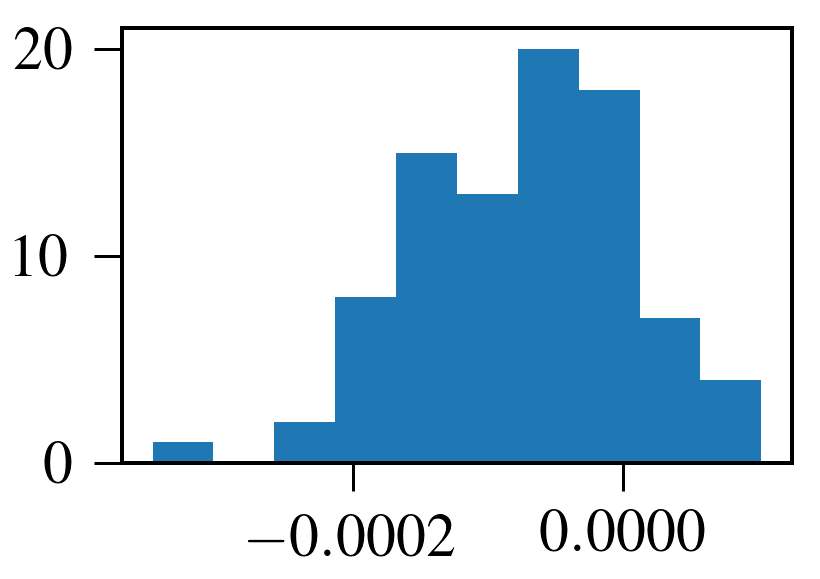

In [17]:
plt.hist(merged.rho_v_UP-merged.rho_v_ORG)

In [70]:
for name, syst in systematics.items():
    
    merged = toy.merge(syst[0],  on='itoy', suffixes=('_ORG', '_UP'))
    A = np.mean((merged.rho_v_UP-merged.rho_v_ORG)/merged.rho_e_ORG)
    AA = np.mean((merged.rho_v_UP-merged.rho_v_ORG))

    merged = toy.merge(syst[1],  on='itoy', suffixes=('_ORG', '_UP'))
    B = np.mean((merged.rho_v_UP-merged.rho_v_ORG)/merged.rho_e_ORG)
    BB = np.mean((merged.rho_v_UP-merged.rho_v_ORG))

    print(name, 0.5*np.abs(AA)+0.5*np.abs(BB))
    print(name, 0.5*np.abs(A)+0.5*np.abs(B), '%')

meson_radius 2.79517518317e-05
meson_radius 0.0908046649246 %


In [3]:
def statistics(pull):
    n = len(pull)
    ratio = np.exp(special.gammaln(n/2.)-special.gammaln((n-1)/2.))
    mean = np.mean(pull)
    std = np.std(pull)
    mean_e = std/np.sqrt(n)
    std_e = std*np.sqrt(1-2./(n-1)*(ratio)**2.)
    return mean, mean_e, std, std_e

def diff(pull):
    n = len(pull)
    mean = np.mean(pull)
    std = np.std(pull)
    mean_e = std/np.sqrt(n)
    return mean, mean_e

In [4]:
diffs = pd.DataFrame({var:(toy[var+'_v'] - true_values[var]) for var in vars_in_sample})
pullsd = {}
for var in vars_in_sample:
    if '_arg' in var:
        pullsd[var] = np.arctan2(np.sin(diffs[var]), np.cos(diffs[var]))/toy[var + '_e']
    else:
        pullsd[var] = diffs[var]/toy[var + '_e']
        
pulls = pd.DataFrame(pullsd)

In [5]:
stuff = []
pmeans = []
pmeanse = []
pstde = []
means = []
pint = []
uncs = []
pstd = []
pidx = []
ppretty = []
pbias = []
pbiase = []
for i, var in enumerate(vars_in_sample):
    m, me, s, se = statistics(pulls[var])
    b, be = diff(diffs[var])
    pmeans += [m]
    pmeanse += [me]
    pstd += [s]
    pstde += [se]
    pidx += [i]
    ppretty += [pretty_names[var]]
    means += [np.mean(toy[var + '_v'])]
    uncs += [np.mean(toy[var + '_e'])]
    pint += [int_unc[var]]
    pbias += [b]
    pbiase += [be]

pmeans = np.array(pmeans)
pmeanse = np.array(pmeanse)
pstd = np.array(pstd)
pstde = np.array(pstde)
pint = np.array(pint)

pint_extra = np.sqrt(pmeanse**2+pint**2)-pmeanse


pidx = np.array(pidx)


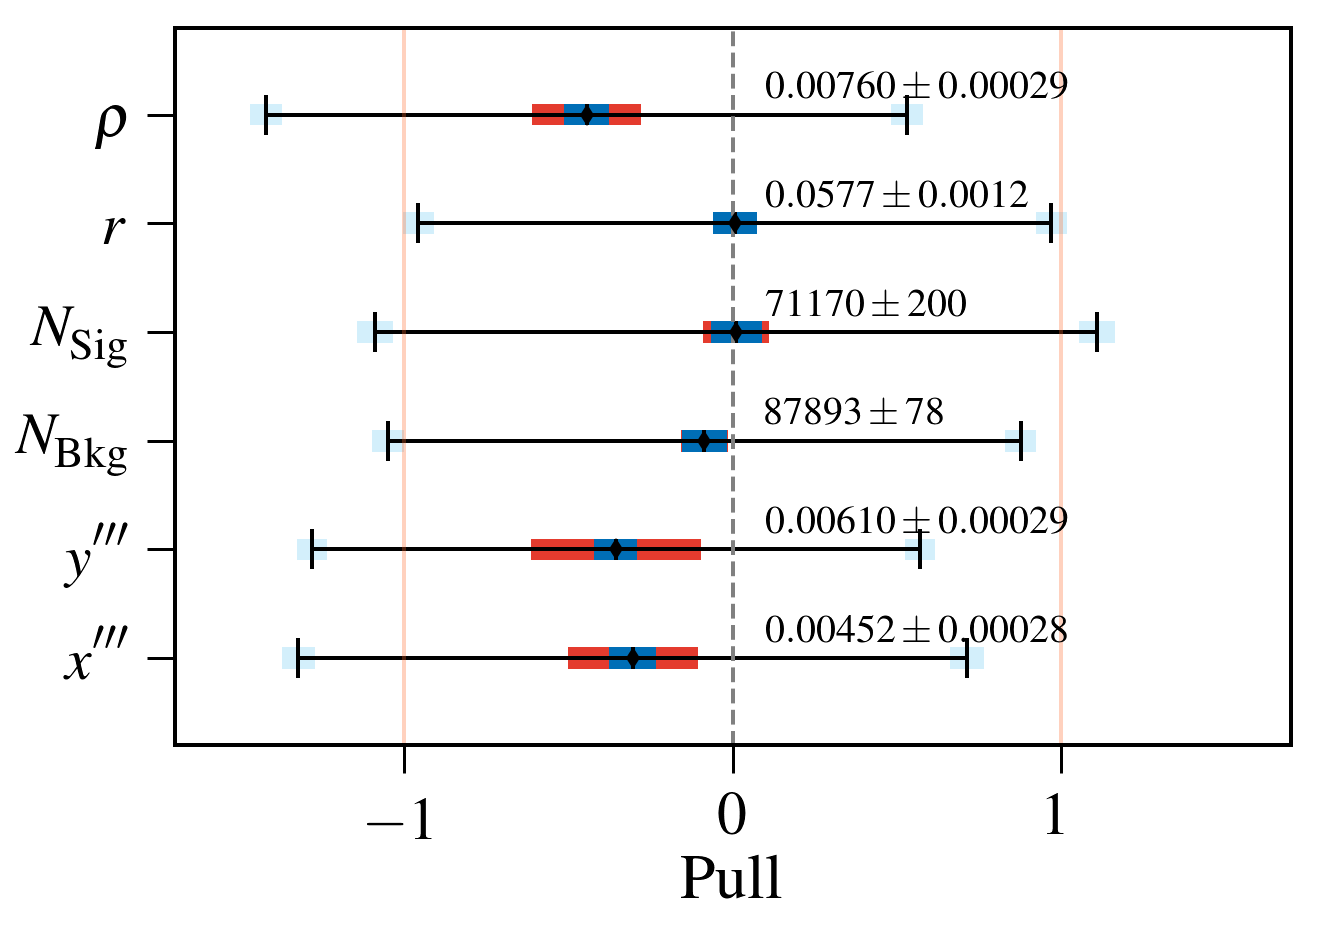

In [6]:
fig, ax = plt.subplots(figsize=(10,1.1*len(pmeans)))
blubl = ax.errorbar(
    pmeans, pidx, 0.1, pstd, fmt='d',
    color='k', ecolor='k', capthick=2, capsize=10
)
ax.plot( [1,1],[-1, pidx[-1]+1], color='#FF6828', alpha=0.3)
ax.plot( [-1,-1],[-1, pidx[-1]+1], color='#FF6828', alpha=0.3)
ax.plot( [0,0],[-1, pidx[-1]+1], linestyle='--', color='grey')

ax.bar(pmeans, np.ones(len(pmeans))*0.2, width=2*pmeanse, bottom=pidx-0.1, color='#006EB6')
ax.bar(pmeans-pmeanse-0.5*pint_extra, np.ones(len(pmeans))*0.2, width=pint_extra, bottom=pidx-0.1, color='#e43b2e')
ax.bar(pmeans+pmeanse+0.5*pint_extra, np.ones(len(pmeans))*0.2, width=pint_extra, bottom=pidx-0.1, color='#e43b2e')
ax.bar(pmeans+pstd, np.ones(len(pstd))*0.2, width=2*pstde, bottom=pidx-0.1, color='#D3EFFB')
ax.bar(pmeans-pstd, np.ones(len(pstd))*0.2, width=2*pstde, bottom=pidx-0.1, color='#D3EFFB')


ax.set_ylim((-0.8, pidx[-1]+0.8))
ax.set_yticks(pidx);
ax.set_yticklabels(ppretty);
ax.set_xlim((-1.7,1.7));
ax.set_xlabel('Pull')

blubl[1][2].set_alpha(0)
blubl[1][3].set_alpha(0)


for i, m, u, n in zip(pidx, means, uncs, ppretty):
    ppb = n.replace('$', '')
    val, prec = helpers.rounder(m, [u], sig_prec=1)
    err, _ = helpers.rounder(u, [u], is_unc=True, sig_prec=1)
    spec = '{{:.{}f}}'.format(prec)
    #arr = r'$\langle {0}\rangle\pm\langle \sigma_{{{0}}}\rangle={1}\pm{2}$'.format(ppb, spec.format(val), spec.format(err))
    arr = r'${1}\pm{2}$'.format(ppb, spec.format(val), spec.format(err))

    ax.annotate(arr, xy=(0.1, i+0.1), fontsize=20, verticalalignment='bottom')
    
for i, m, u, n in zip(pidx, pbias, pbiase, ppretty):
    ppb = n.replace('$', '')
    val, prec = helpers.rounder(m, [u], sig_prec=1)
    err, _ = helpers.rounder(u, [u], is_unc=True, sig_prec=1)
    spec = '{{:.{}f}}'.format(prec)
    arr = r'$\langle \Delta_{{{0}}}\rangle={1}$'.format(ppb, spec.format(val))
    #ax.annotate(arr, xy=(-1.5, i+0.1), fontsize=20, verticalalignment='bottom')

with MODE('MagBoth', 1516, 'WS'):
    outfile = gcm().get_output_path('amplitude_fit/' + outpath) + f'pulls_overview_{outsuffix}.pdf'
    fig.savefig(outfile)

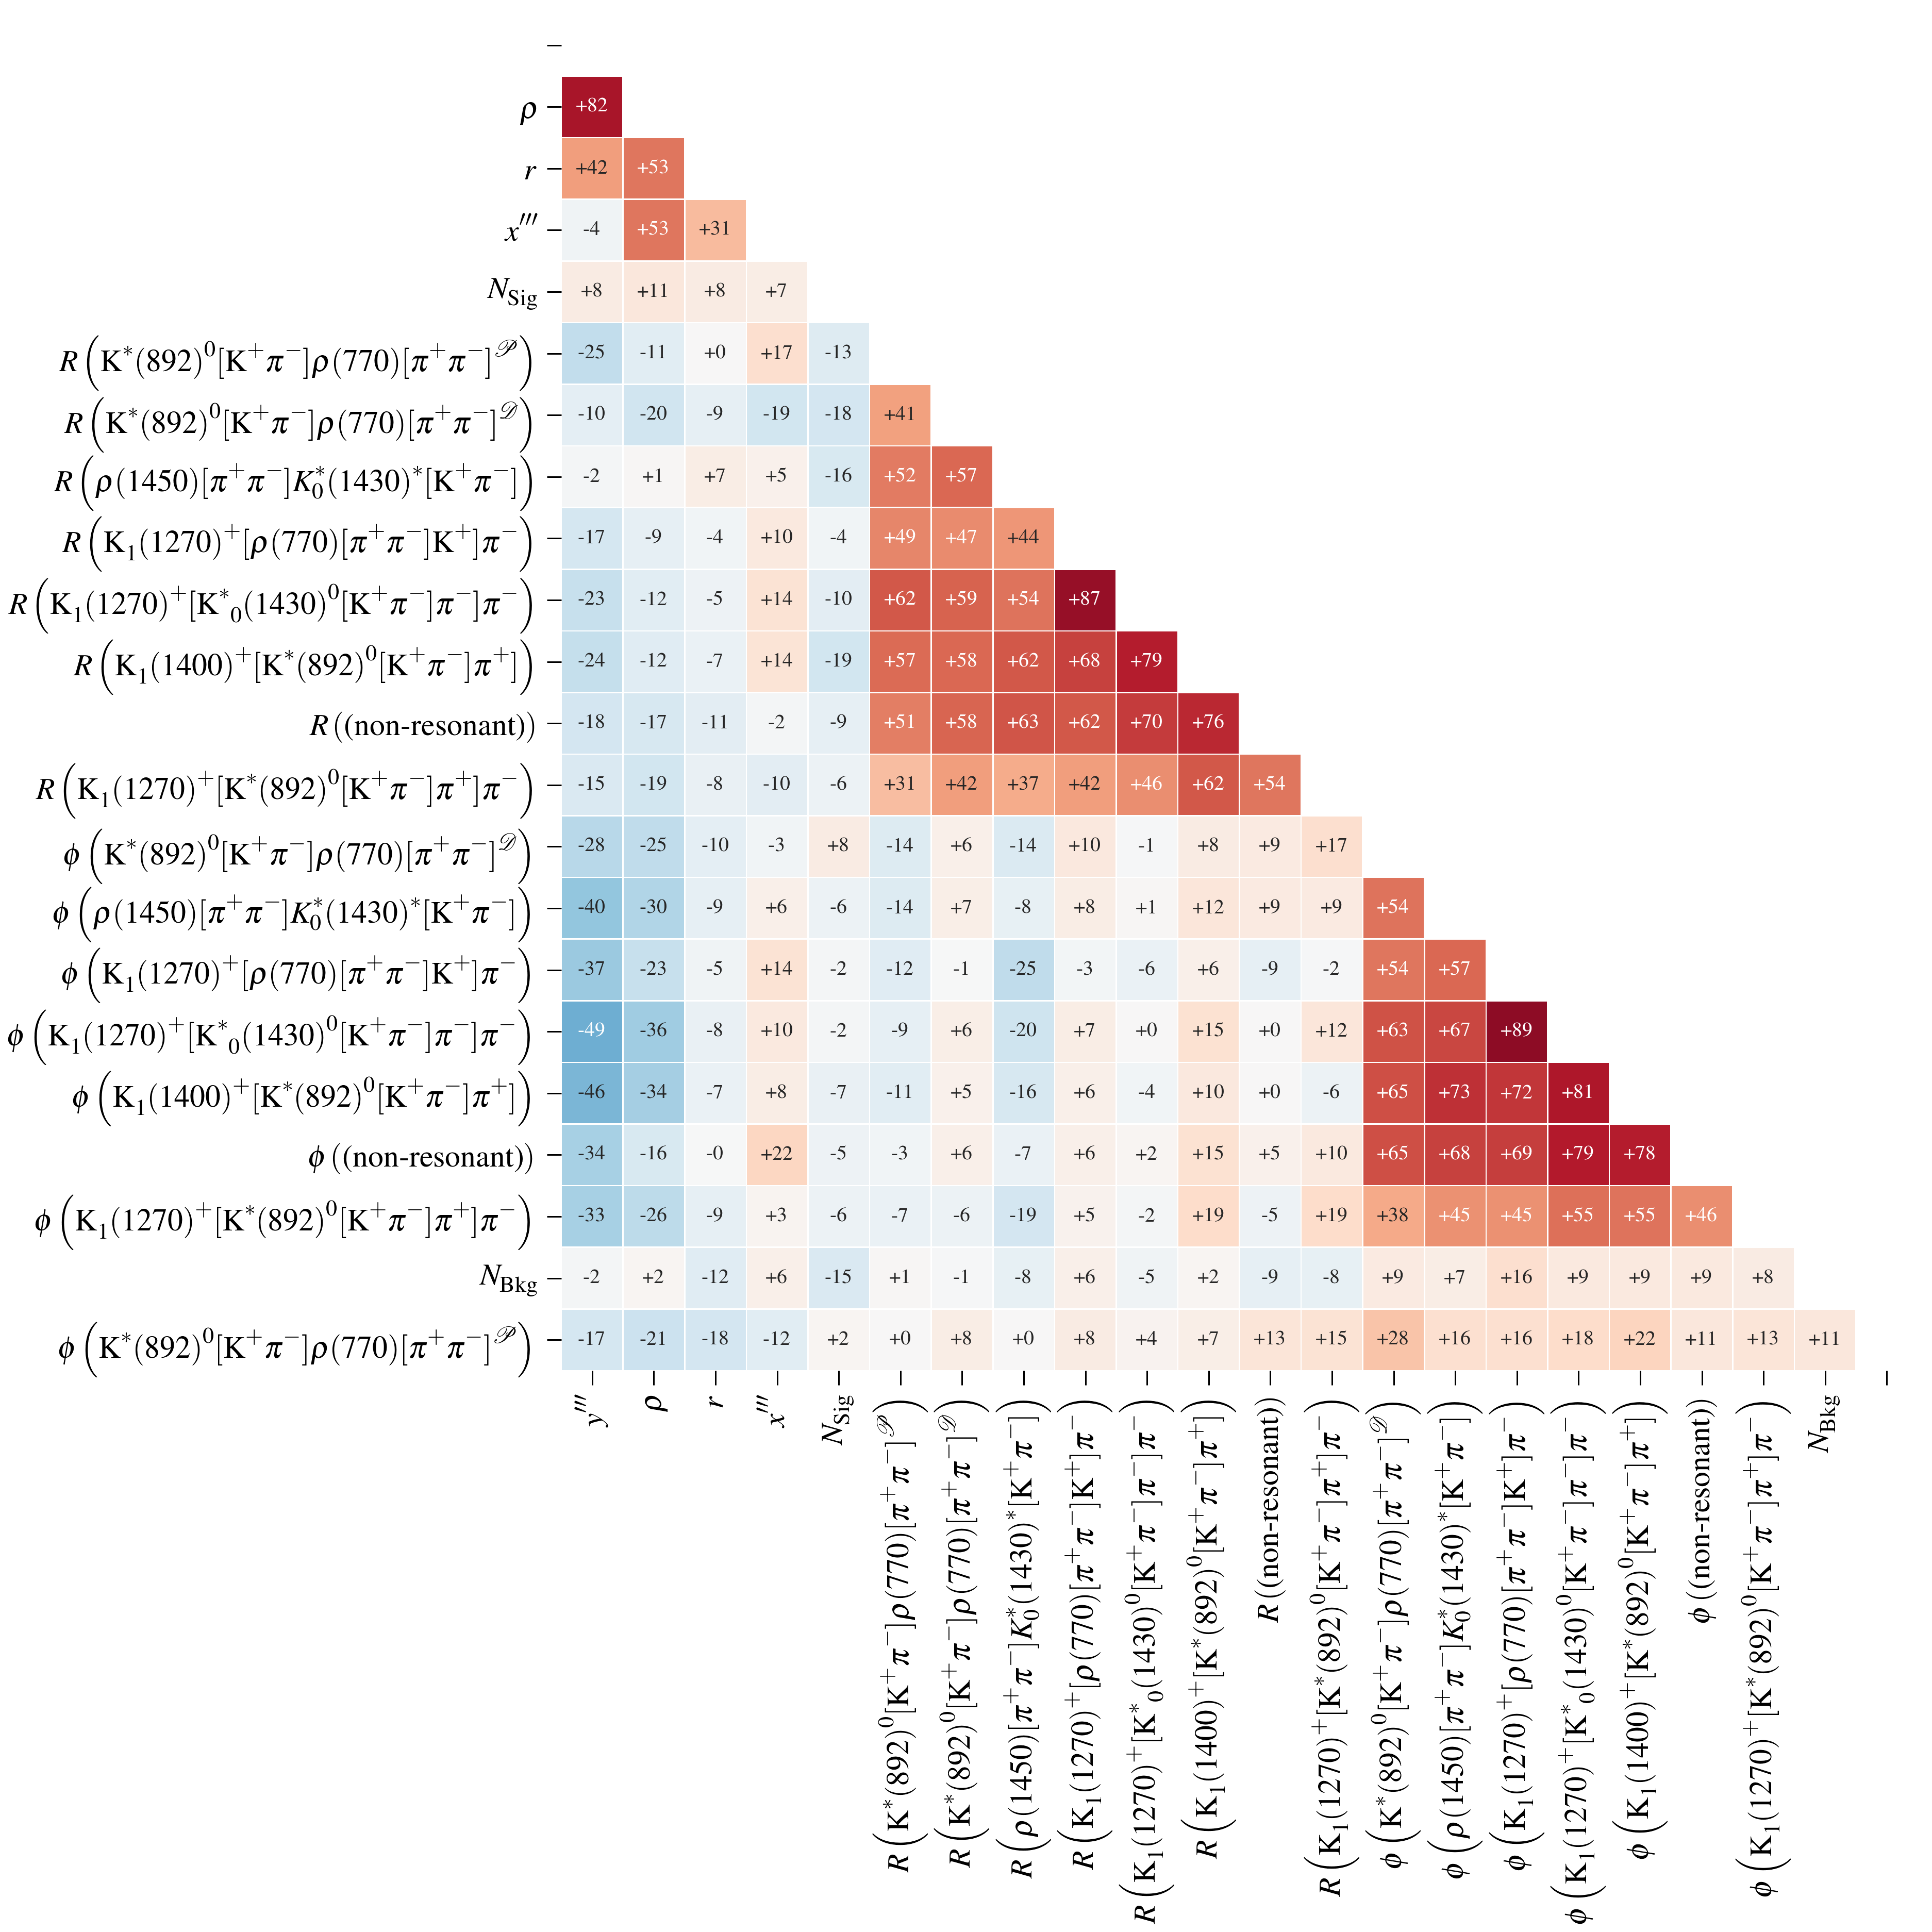

In [75]:
import seaborn.apionly as sns
import matplotlib.pyplot as plt
from k3pi_utilities import parser
from scipy.cluster import hierarchy
from analysis import selection, add_variables
from k3pi_config.modes import MODE, gcm
import numpy as np
from k3pi_utilities.variables import m, dtf_dm


varlist = [c + '_v' for c in vars_in_sample]
nlist = [pretty_names[v.replace('_v', '')] for v in varlist]

df = toy[varlist]

correlations = df.corr()
correlations_array = np.asarray(df.corr())

row_linkage = hierarchy.linkage(correlations_array, method='average')

from scipy.cluster.hierarchy import fcluster
clusters = fcluster(row_linkage, 10, criterion='maxclust')

clustered = list(next(zip(*sorted(zip(varlist, clusters), key=lambda x: x[1]))))
clustered_names = list(next(zip(*sorted(zip(nlist, clusters), key=lambda x: x[1]))))
correlations = correlations[clustered].loc[clustered]*100

f, ax = plt.subplots(figsize=(1.1*len(pmeans), 1.1*len(pmeans)))
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

bla = sns.heatmap(correlations, mask=mask, annot=True,
                  ax=ax, vmin=-100, annot_kws={'fontsize': 20},
                  square=True, vmax=100, fmt="+2.0f", linewidths=.8,
                  yticklabels=clustered_names[1:],
                  xticklabels=clustered_names[:-1], cbar=False);
bla.set_xticklabels(bla.get_xticklabels(), rotation=90, fontsize=30);
bla.set_yticklabels(bla.get_yticklabels(), rotation=0, fontsize=30);

with MODE('MagBoth', 1516, 'WS'):
    outfile = gcm().get_output_path('amplitude_fit/' + outpath) + f'correlations_{outsuffix}.pdf'
    f.savefig(outfile)


In [65]:
uncRes = [[],[],[],[]]
        
log = open('./log.txt','r')
switchOn = False
muIDX = -1
for aline in log.readlines():
    if 'FinalValue' in aline:
        switchOn = True
        uncRes = [[],[],[],[]]
        muIDX = -1
        continue
    if '------------' in aline: continue
    if switchOn:
        if 'gamma_stat' in aline: continue
        if 'QCDNorm' in aline: continue
        if 'mu_' in aline and muIDX<0:
            muIDX=len(uncRes[0])
        if len(aline.strip())<3:
            switchOn=False
            continue
                              
        if 'mu_' in aline:
            uncRes[0] += [ aline.split()[0]+'-1' ]
            uncRes[1] += [ float(aline.split()[2])-1.]
        if 'Lumi' in aline:
            uncRes[0] += [ aline.split()[0]+'-1' ]
            uncRes[1] += [ float(aline.split()[2])-1.]
        if 'alpha_' in aline:
            uncRes[0] += [ aline.split()[0].replace('alpha_','') ]
            uncRes[1] += [ float(aline.split()[2]) ]
        if ' +/- ' in aline:
            uncRes[2] += [ float(aline.split()[4]) ]
            uncRes[3] += [ float(aline.split()[4]) ]
        else:
            if len(aline.strip())<2: continue
            brief = (aline.split()[3].split('(')[1].split(')')[0]).replace('--','-')
            uncRes[2] += [ abs(float(brief.split(',')[0])) ]
            uncRes[3] += [ abs(float(brief.split(',')[1])) ]
            if uncRes[2][-1]<0.00001: uncRes[2][-1]=uncRes[3][-1]
            if uncRes[3][-1]<0.00001: uncRes[3][-1]=uncRes[2][-1]

In [68]:
names = [r'\texttt{{{}}}'.format(n.replace('_', '\_')) for n in uncRes[0]]
x = np.array(uncRes[1])
xep = np.array(uncRes[2])
xem = np.array(uncRes[3])
y = np.array([ a for a in range( len(uncRes[1]) ) ] )
ye = np.array([ 0 for a in range( len(uncRes[1]) ) ] )

In [43]:
import uncertainties

ModuleNotFoundError: No module named 'uncertainties'

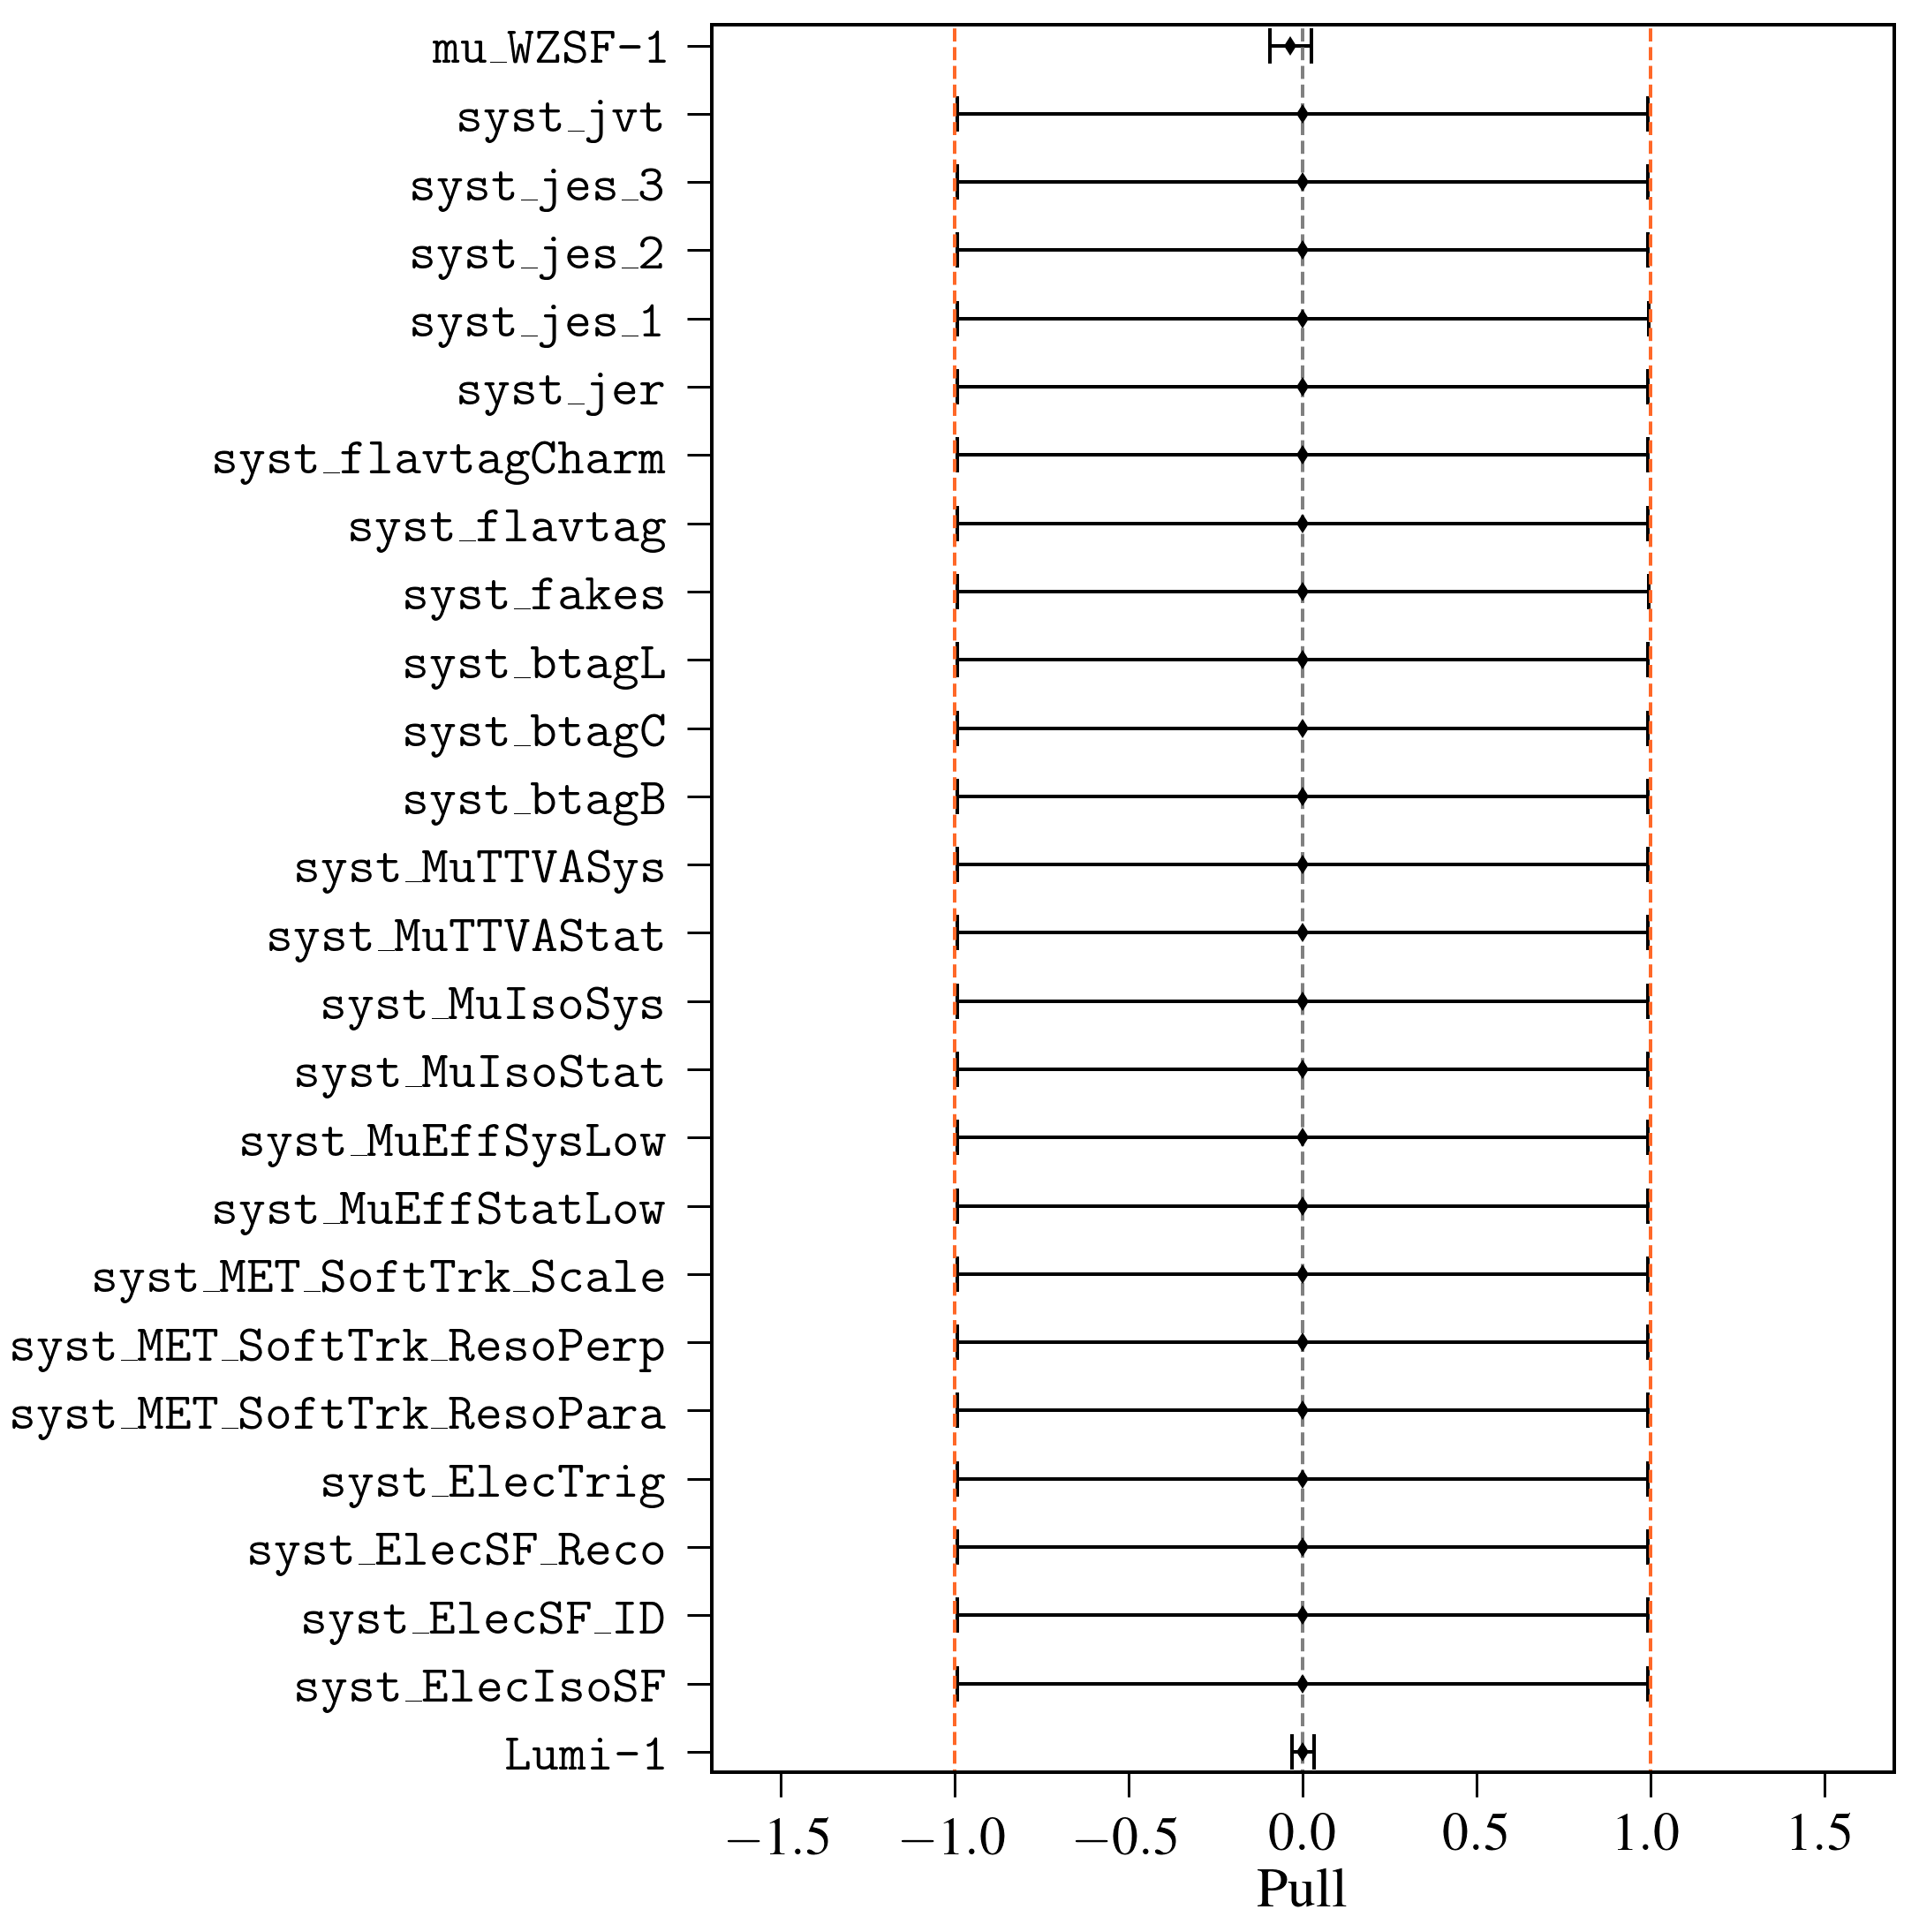

In [76]:
fig, ax = plt.subplots(figsize=(12,0.7*len(names)))
blubl = ax.errorbar(
    x, y, 0.1, xep, fmt='d',
    color='k', ecolor='k', capthick=2, capsize=10
)
ax.plot( [1,1],[-1, y[-1]+1], linestyle='--', color='#FF6828')
ax.plot( [-1,-1],[-1, y[-1]+1], linestyle='--', color='#FF6828')
ax.plot( [0,0],[-1, y[-1]+1], linestyle='--', color='grey')

ax.set_ylim((-0.3, y[-1]+0.3))
ax.set_yticks(y);
ax.set_yticklabels(names);
ax.set_xlim((-1.7,1.7));
ax.set_xlabel('Pull')

blubl[1][2].set_alpha(0)
blubl[1][3].set_alpha(0)

In [18]:
import uncertainties as uncs

In [132]:
x = uncs.ufloat(np.mean(toy['xmixing_v']), np.mean(np.sqrt(toy['xmixing_e']**2 + (0.15*toy['xmixing_e'])**2)))

In [133]:
y = uncs.ufloat(np.mean(toy['ymixing_v']), np.mean(np.sqrt(toy['ymixing_e']**2 + (0.15*toy['ymixing_e'])**2)))

In [4]:
x = 0.0046
y = 0.0062
r_cf = 1.
r_dcs=1./sqrt(300)

In [222]:
nf = num_fractions[-1]
ef = ext_fractions[-1]

In [224]:
start = 1./nf

In [5]:
from scipy.stats import poisson
@np.vectorize
def boundary(nf, ef):
    if nf > ef:
        #print(f'nf bigger')

        start = 1./ef
        Ne = np.logspace(np.log10(start),18, 10000, dtype=np.float)*ef
        Nn = np.logspace(np.log10(start),18, 10000, dtype=np.float)*nf
        mmh = poisson.isf(0.84, Nn)
        return Nn[mmh >= Ne][0]/nf
    else:
        #print(f'ef bigger')

        start = 1./nf
        Ne = np.logspace(np.log10(start),18, 10000, dtype=np.float)*ef
        Nn = np.logspace(np.log10(start),18, 10000, dtype=np.float)*nf
        mmh = poisson.isf(0.16, Nn)
        return Nn[mmh < Ne][0]/nf

In [6]:
# Define constant terms in the calculation
A = r_dcs**2
B = r_cf**2*(x**2+y**2)/4.
C = r_dcs*r_cf*(y*np.cos(np.pi/2.)-x*np.sin(np.pi/2.))

# Suppressed term
D = r_dcs**2*(y**2-x**2)/4.
# 3rd order term
E = ((y**3*np.cos(np.pi/2.)+x**3*np.sin(np.pi/2.))) * r_cf * r_dcs/6

# Integrals
int_linear = A-C
int_nominal = A+2*B-C
int_extra = A+2*(B+D)-C
int_third = A+2*B-C+6.*E

def int_linear_indef(low, high):
    upper = np.exp(-high)*(-A+high*(C)-2*B+C)
    upper /= int_linear
    
    lower = np.exp(-low)*(-A+low*(C)-2*B+C)
    lower /= int_linear
    return upper - lower

def int_nominal_indef(low, high):
    upper = np.exp(-high)*(-A+high*(C-2*B)-B*high**2-2*B+C)
    upper /= int_nominal
    
    lower = np.exp(-low)*(-A+low*(C-2*B)-B*low**2-2*B+C)
    lower /= int_nominal
    return upper - lower

def int_extra_indef(low, high):
    upper = np.exp(-high)*(-A+high*(C-2*(B+D))-(B+D)*high**2-2*(B+D)+C)
    upper /= int_extra
    
    lower = np.exp(-low)*(-A+low*(C-2*(B+D))-(B+D)*low**2-2*(B+D)+C)
    lower /= int_extra
    return upper - lower

def int_third_indef(low, high):
    upper = np.exp(-high)*(-A+high*(C-2*B-6*E)+(-B-3*E)*high**2-2*B+C-E*high**3-6*E)
    upper /= int_third
    
    lower = np.exp(-low)*(-A+low*(C-2*B-6*E)+(-B-3*E)*low**2-2*B+C-E*low**3-6*E)
    lower /= int_third
    return upper - lower

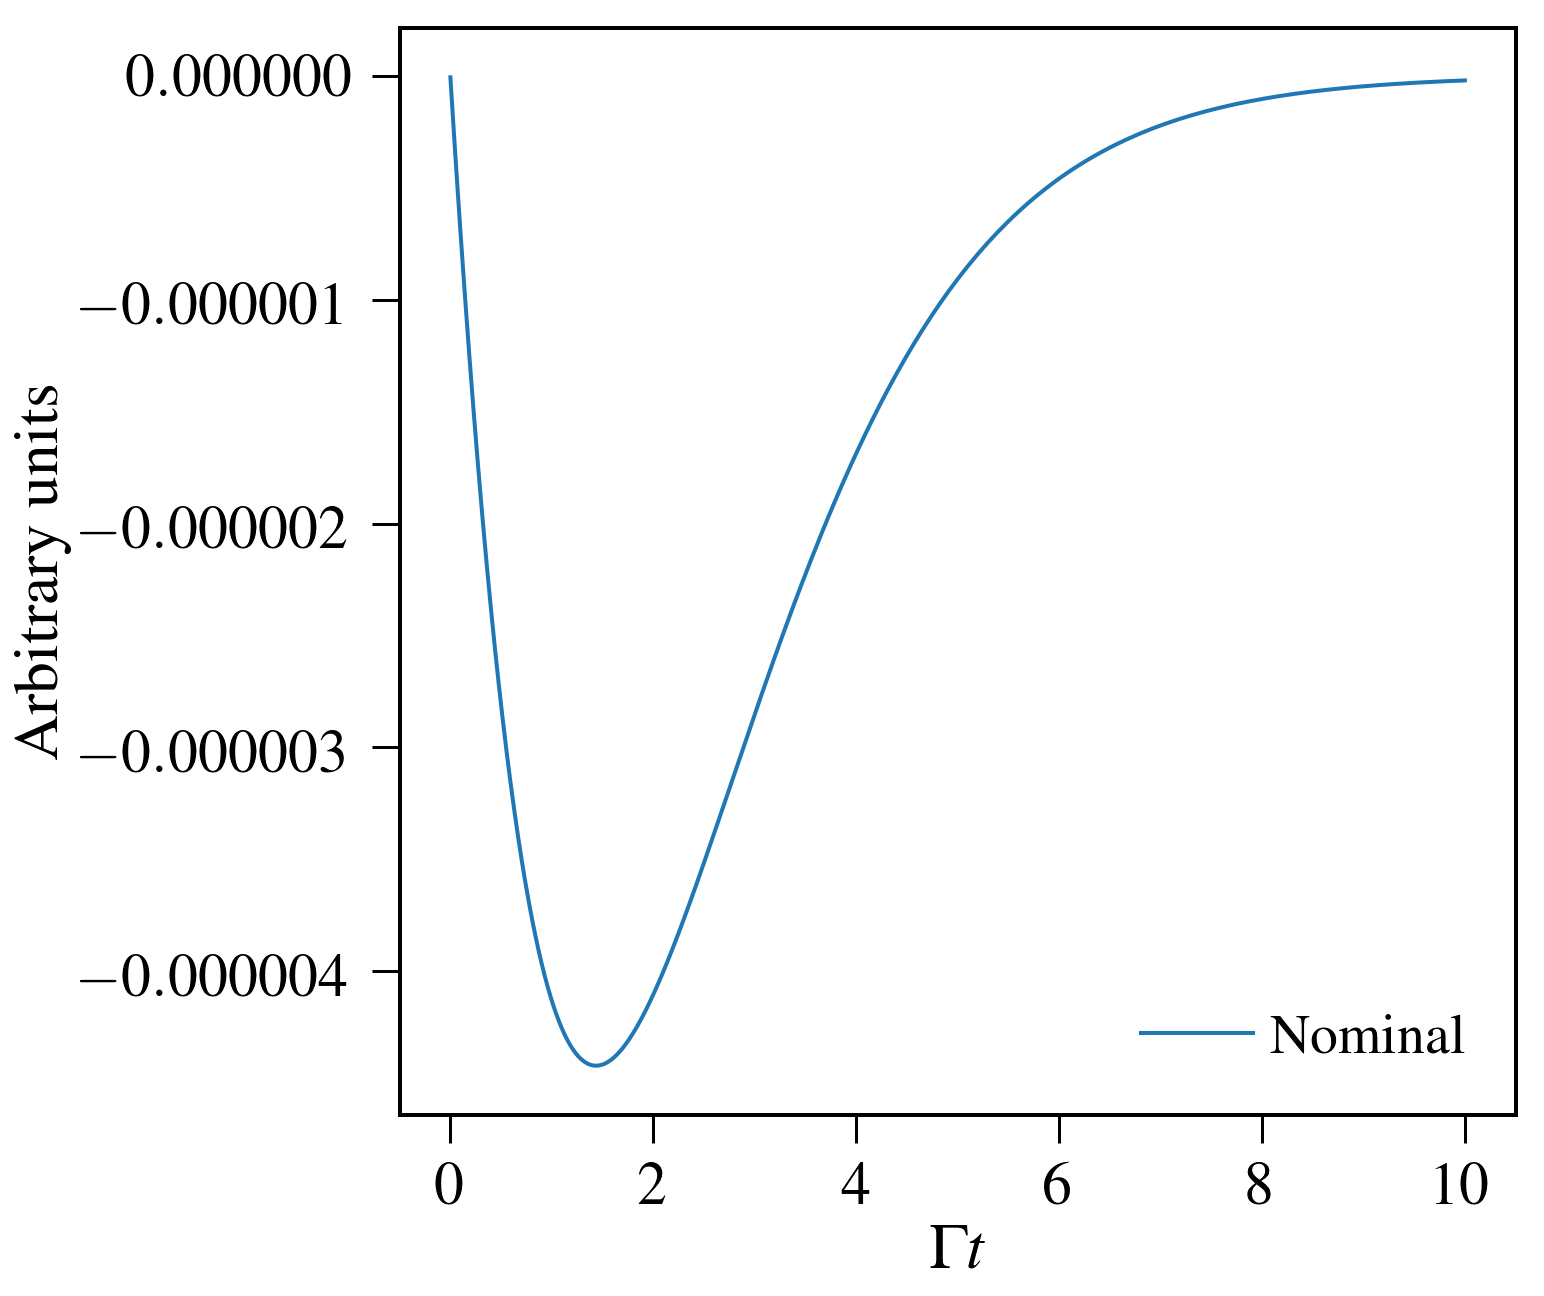

In [135]:
xs = np.logspace(-3,np.log10(10),1000)
ys_nom = np.exp(-xs)*(A + B*xs**2-E*xs)/int_nominal
ys_linear = np.exp(-xs)*(A - E*xs)/int_linear
ys_extra = np.exp(-xs)*(A + (B+D)*xs**2 - E*xs)/int_extra

fig, ax = plt.subplots(figsize=(10,10))
#ax.plot(xs, ys_nom-ys_linear, label=r'Nominal')
#ax.plot(xs, ys_nom, label=r'$|A_{DCS}|^2\frac{y^2-x^2}{4}(\Gamma t)^2$')
#ax.plot(ctrs, bnds_third, label=r'3$^\mathrm{rd}$ order in $\Gamma t$')
#ax.plot(xs, ys_linear, label=r'-$|A_{CF}|^2\frac{y^2+x^2}{4}(\Gamma t)^2$')

lbnds = xs
ubnds = np.ones(len(lbnds))*20.
ctrs = lbnds
num_fractions = int_nominal_indef(lbnds, ubnds)
ext_fractions = int_extra_indef(lbnds, ubnds)
thr_fractions = int_third_indef(lbnds, ubnds)
lin_fractions = int_linear_indef(lbnds, ubnds)

ax.plot(xs, num_fractions-ext_fractions, label=r'Nominal')
#ax.plot(xs, lin_fractions, label=r'$-|A_{CF}|^2\frac{y^2+x^2}{4}(\Gamma t)^2$')

#ax.set_yscale('log')
ax.set_xlabel(r'$\Gamma t$')
ax.set_ylabel(r'Arbitrary units')
ax.legend()
#plot_utils.y_margin_scaler(ax, lf=0.1, hf=0.25, log=True)
plt.savefig('sensitivity_estimate_cuvres.pdf')


In [13]:
edges = np.logspace(-0.001,np.log10(20),100)

In [166]:
#lbnds, ubnds = np.linspace(0,20, 200), np.linspace(1,21, 200)
lbnds, ubnds = edges[:-1], edges[1:]
edges = expon.ppf(np.linspace(0.0001, int_nominal_indef(0, 20), 200))
lbnds, ubnds = edges[:-1], edges[1:]
ctrs = (lbnds + ubnds)/2.
num_fractions = int_nominal_indef(lbnds, ubnds)
ext_fractions = int_extra_indef(lbnds, ubnds)
thr_fractions = int_third_indef(lbnds, ubnds)
lin_fractions = int_linear_indef(lbnds, ubnds)

In [167]:
bnds = boundary(num_fractions, ext_fractions)
bnds_third = boundary(num_fractions, thr_fractions)
bnds_linear = boundary(num_fractions, lin_fractions)

/afs/cern.ch/user/d/dmuller/work/anaconda3/envs/k3pi_python3/lib/python3.6/site-packages/scipy/stats/_discrete_distns.py:485: RuntimeWarning: floating point number truncated to an integer
  temp = special.pdtr(vals1, mu)
/afs/cern.ch/user/d/dmuller/work/anaconda3/envs/k3pi_python3/lib/python3.6/site-packages/scipy/stats/_discrete_distns.py:486: RuntimeWarning: invalid value encountered in greater_equal
  return np.where(temp >= q, vals1, vals)


In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(ctrs, bnds, label=r'$|A_{DCS}|^2\frac{y^2-x^2}{4}(\Gamma t)^2$')
ax.plot(ctrs, bnds_third, label=r'3$^\mathrm{rd}$ order in $\Gamma t$')
ax.plot(ctrs, bnds_linear, label=r'-$|A_{CF}|^2\frac{y^2+x^2}{4}(\Gamma t)^2$')

ax.set_yscale('log')
ax.set_xlabel(r'$\Gamma t$')
ax.set_ylabel(r'Number of events for $p=16\%$')
ax.legend()
plot_utils.y_margin_scaler(ax, lf=0.1, hf=0.25, log=True)
plt.savefig('sensitivity_estimate_pro2.pdf')

In [14]:
lbnds = edges[:-1]
ubnds = np.ones(len(lbnds))*20.
ctrs = lbnds
num_fractions = int_nominal_indef(lbnds, ubnds)
ext_fractions = int_extra_indef(lbnds, ubnds)
thr_fractions = int_third_indef(lbnds, ubnds)
lin_fractions = int_linear_indef(lbnds, ubnds)

In [15]:
bnds = boundary(num_fractions, ext_fractions)
bnds_third = boundary(num_fractions, thr_fractions)
bnds_linear = boundary(lin_fractions, num_fractions)

/afs/cern.ch/user/d/dmuller/work/anaconda3/envs/k3pi_python3/lib/python3.6/site-packages/scipy/stats/_discrete_distns.py:485: RuntimeWarning: floating point number truncated to an integer
  temp = special.pdtr(vals1, mu)
/afs/cern.ch/user/d/dmuller/work/anaconda3/envs/k3pi_python3/lib/python3.6/site-packages/scipy/stats/_discrete_distns.py:486: RuntimeWarning: invalid value encountered in greater_equal
  return np.where(temp >= q, vals1, vals)


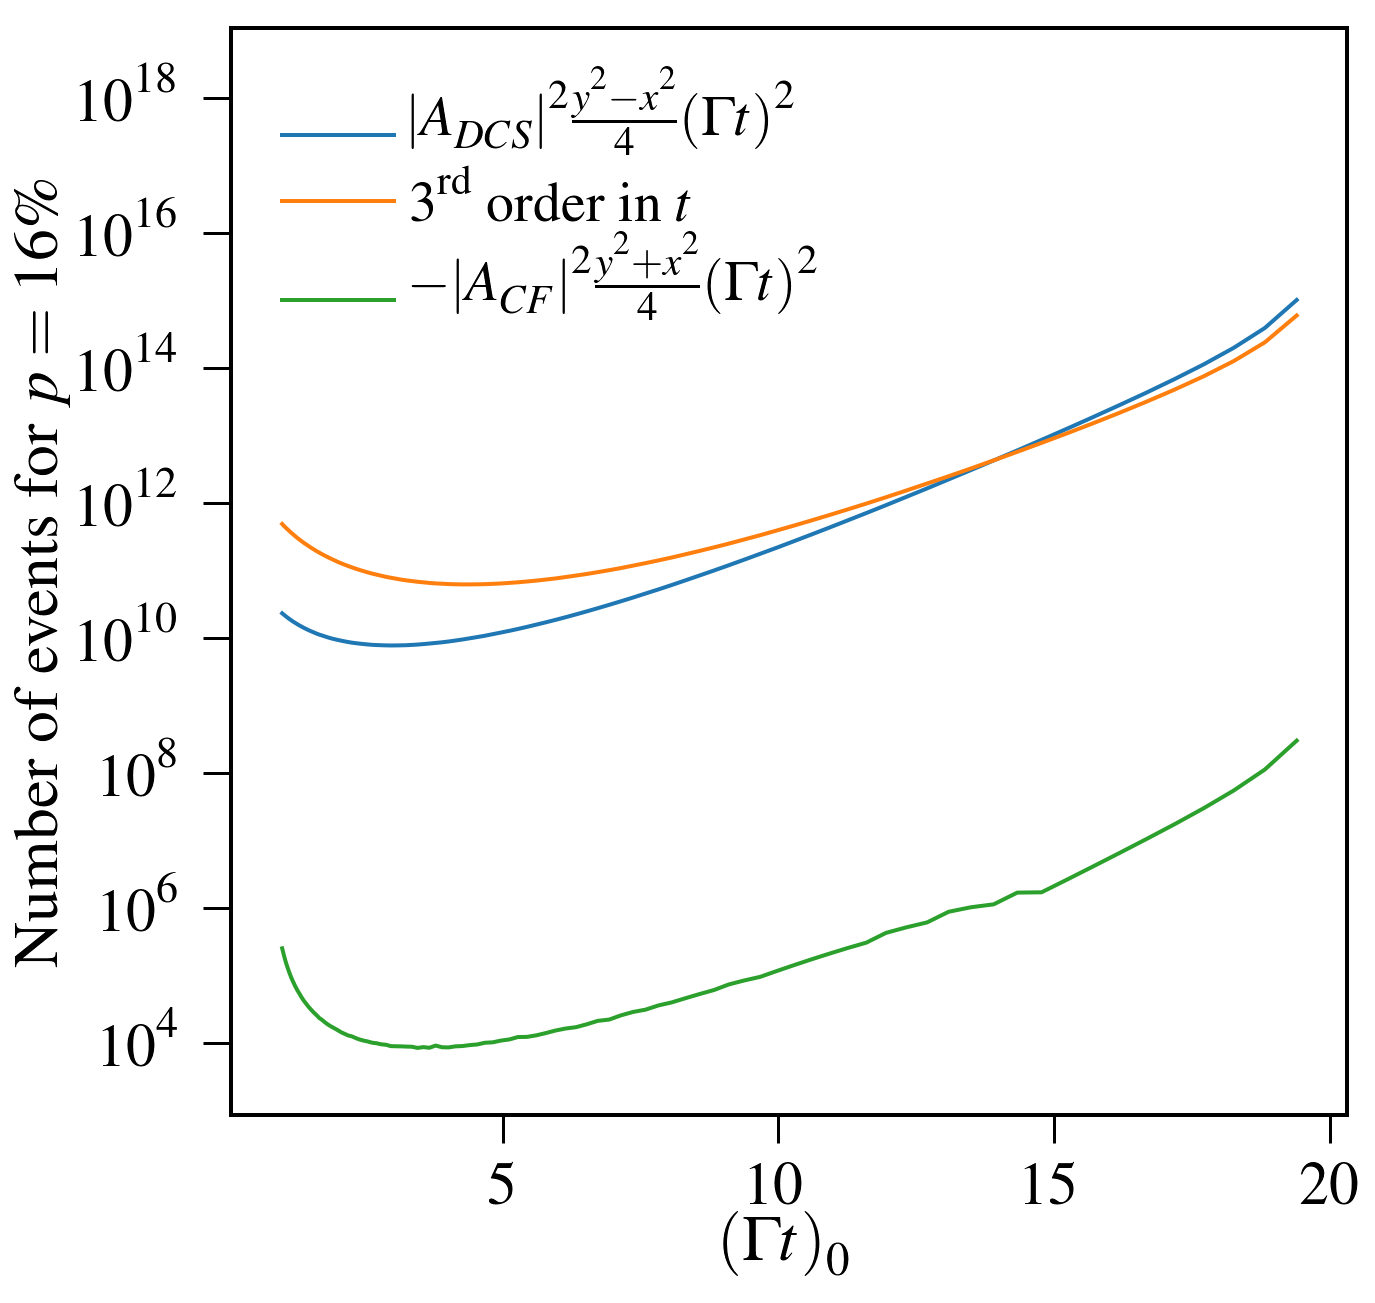

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(ctrs, bnds, label=r'$|A_{DCS}|^2\frac{y^2-x^2}{4}(\Gamma t)^2$')
ax.plot(ctrs, bnds_third, label=r'3$^\mathrm{rd}$ order in $t$')
ax.plot(ctrs, bnds_linear, label=r'$-|A_{CF}|^2\frac{y^2+x^2}{4}(\Gamma t)^2$')

ax.set_yscale('log')
ax.set_xlabel(r'$(\Gamma t)_0$')
ax.set_ylabel(r'Number of events for $p=16\%$')
ax.legend()
plot_utils.y_margin_scaler(ax, lf=0.1, hf=0.25, log=True)
plt.savefig('sensitivity_estimate_integrated2.pdf')

In [138]:
@np.vectorize
def ratio_of_stat(time):
    current = current_approx(time)
    ommitted = r_dcs**2*(y**2-x**2)/4*time**2
    return ommitted.n/current

In [139]:
@np.vectorize
def ratio_of_stat_3rd(time):
    current = current_approx(time)
    ommitted = (time*(y*np.cos(np.pi/2.)-x*np.sin(np.pi/2.)))**3 * r_cf * r_dcs/6
    return ommitted.n/current

@np.vectorize
def ratio_favoured(time):
    current = current_approx(time)
    ommitted = r_cf * (x**2+y**2)/4*time**2
    return ommitted.n/current

In [106]:
xs = np.linspace(1,30, 2000)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(xs, ys, label='|A_{DCS}|^2\frac{y^2-x^2}{4}(\Gamma t)^2')
ax.plot(xs, ys3rd, label='|A_{CF}||A_{DCS}|\frac{(y\Gamma t)^3}{6}')

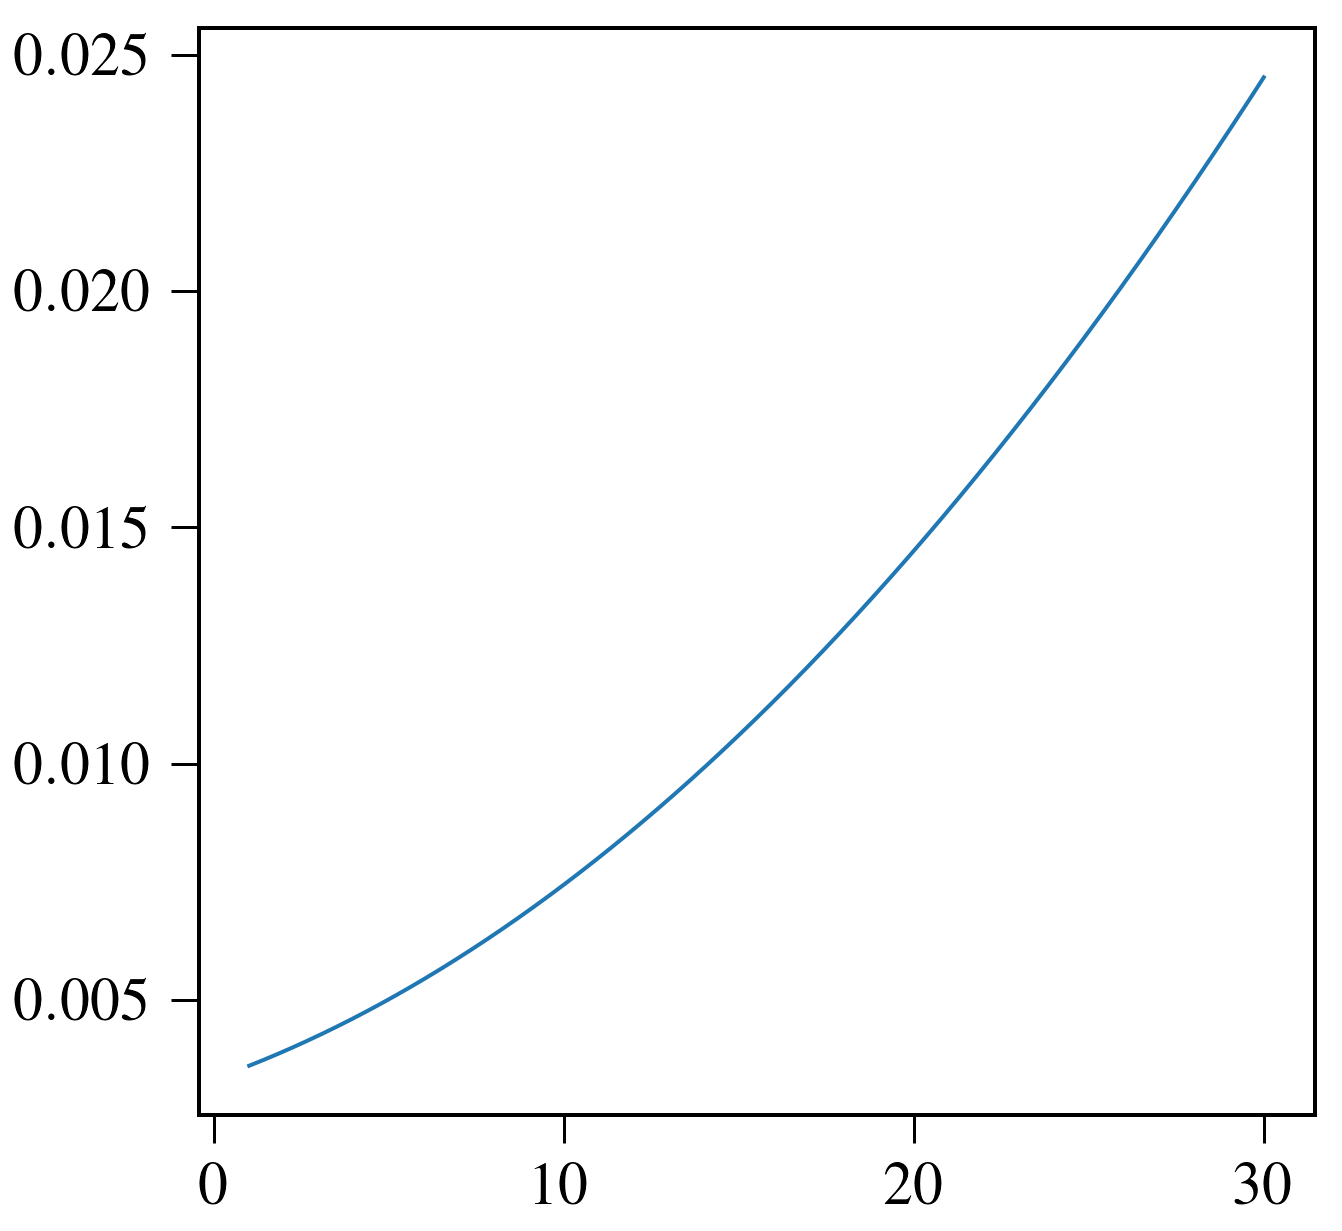

In [103]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(xs, current_approx(xs))


In [140]:
ys = ratio_of_stat(xs)
ys3rd = np.abs(ratio_of_stat_3rd(xs))
ysfav = ratio_favoured(xs)

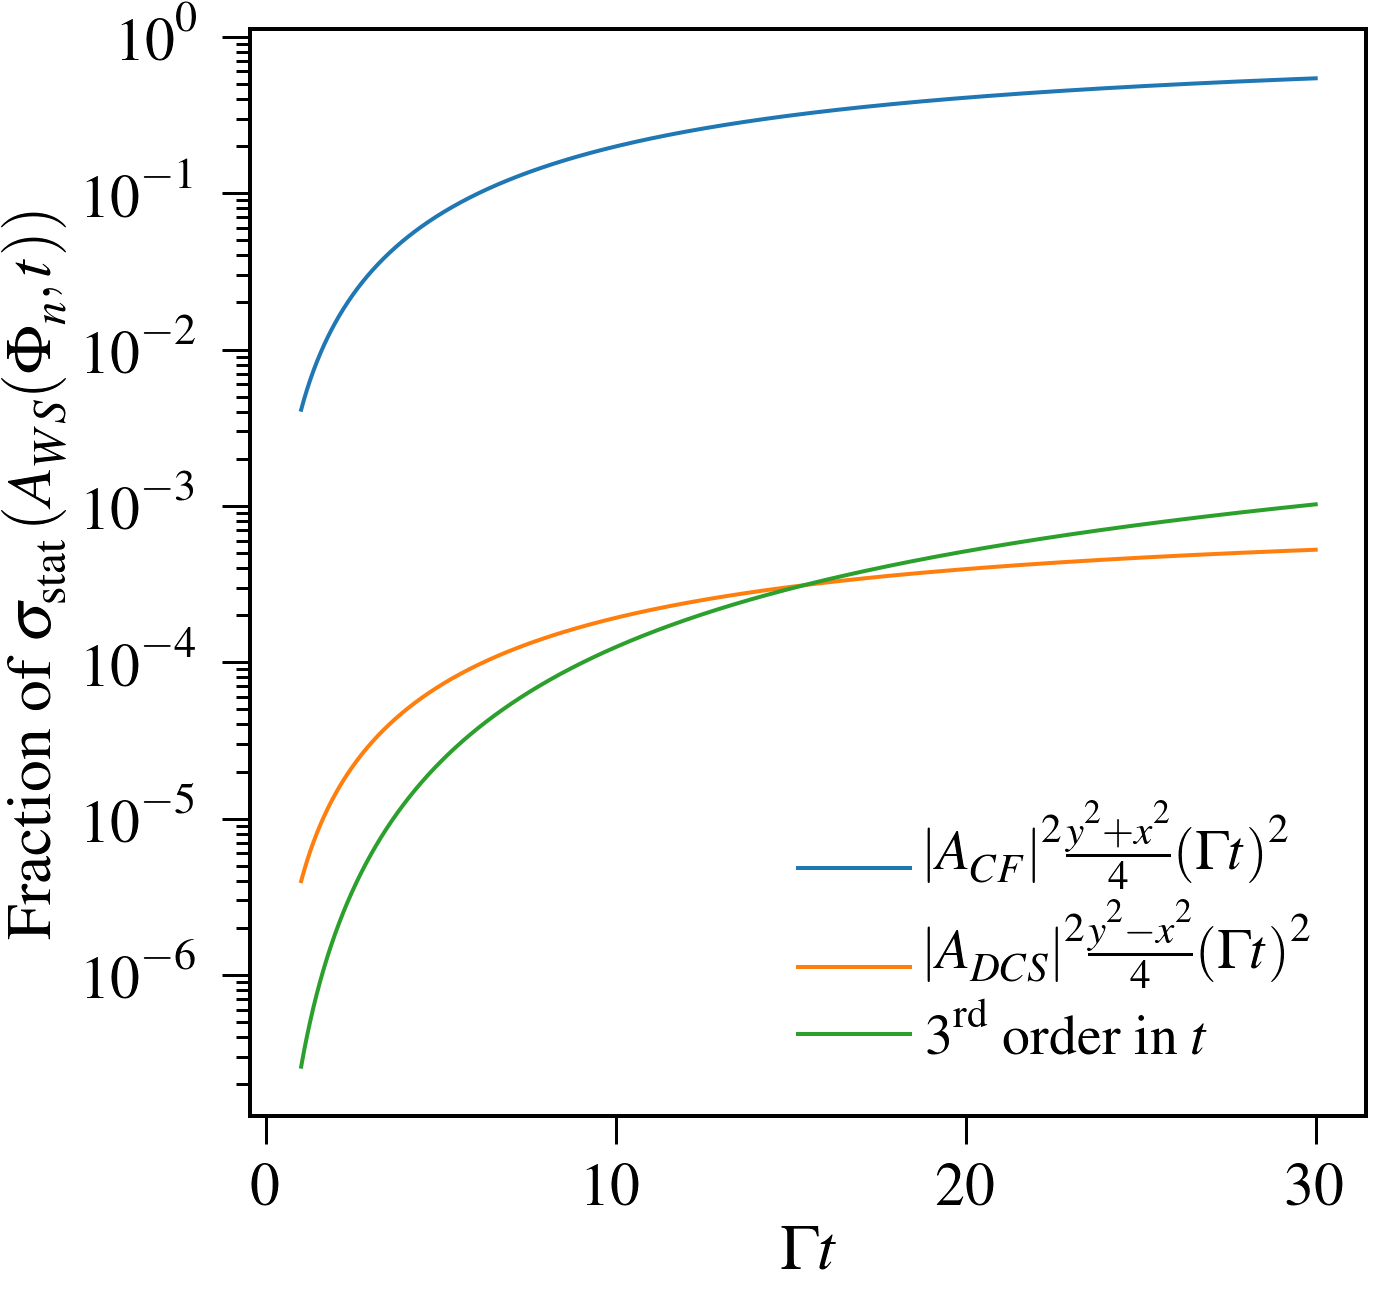

In [141]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(xs, ysfav, label=r'$|A_{CF}|^2\frac{y^2+x^2}{4}(\Gamma t)^2$')
ax.plot(xs, ys, label=r'$|A_{DCS}|^2\frac{y^2-x^2}{4}(\Gamma t)^2$')
ax.plot(xs, ys3rd, label=r'3$^\mathrm{rd}$ order in $t$')


ax.legend()
ax.set_xlabel(r'$\Gamma t$')
ax.set_ylabel(r'Fraction of $\sigma_{\mathrm{stat}}\left(A_{WS}(\Phi_n, t)\right)$')
ax.set_yscale('log')

plt.savefig('sensitivity_estimate2.pdf')

In [66]:
bla3 = (time*y)**3 * r_cf * r_dcs/6

In [69]:
bla.s/bla3.n

243.27580703534278

In [124]:
ls

2tag.ipynb          long_toys/                  spearmint_cuts.pyc
analysis/           matplotlibrc                test2.root
blabla.pdf          MC_tests.ipynb              test.root
blub.txt            MisIDStudies.ipynb          testy
conda.sh            mongodbdir/                 toy.cu
config.json*        mongo.log                   toy_data.root
CPP/                notebooks/                  ToyPulls.ipynb
DaVinciDev_v41r2/   output/                     toy_results/
EffForGoofit.ipynb  out_testy                   Untitled1.ipynb
Fitting.ipynb       PHSP_comparison_test.ipynb  Untitled2.ipynb
job_options/        RapidSim/                   Untitled3.ipynb
k3pi_config/        README.md                   Untitled4.ipynb
k3pi_plotting/      README_zsh.md               Untitled5.ipynb
k3pi_root/          requirements.txt            Untitled6.ipynb
k3pi_utilities/     sensitivity_estimate.pdf    Untitled.ipynb
LICENSE*            setup.sh                    Untitled.py
log.txt       